In [1]:
import math
import numpy as np
import pandas as pd


import nltk
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.stem.snowball import SnowballStemmer

from collections import defaultdict

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt

In [2]:
# Get data
ALL_DATA = pd.read_csv("spam.csv", usecols=[0, 1], encoding_errors="ignore")
TRAIN_PERCENT = 0.80
TRAIN_DATA = ALL_DATA[:int(TRAIN_PERCENT * len(ALL_DATA))]
DEV_DATA = ALL_DATA[int(TRAIN_PERCENT * len(ALL_DATA)):]
DEV_DATA.reset_index()

,index,v1,v2
0,4457,ham,Die... I accidentally deleted e msg i suppose ...
1,4458,spam,Welcome to UK-mobile-date this msg is FREE giv...
2,4459,ham,This is wishing you a great day. Moji told me ...
3,4460,ham,Thanks again for your reply today. When is ur ...
4,4461,ham,"Sorry I flaked last night, shit's seriously go..."
...,...,...,...
1110,5567,spam,This is the 2nd time we have tried 2 contact u...
1111,5568,ham,Will _ b going to esplanade fr home?
1112,5569,ham,"Pity, * was in mood for that. So...any other s..."
1113,5570,ham,The guy did some bitching but I acted like i'd...


In [3]:
def generate_tuples_from_data(data) -> list:
    """
    Generates tuples from data frame formated like:

    tokenized text from file: [[word1, word2, ...], [word1, word2, ...], ...]
    labels: [0, 1, 0, 1, ...]

    Parameters:
        data - data frame with data to separate
    Return:
        a list of lists of tokens and a list of int labels
    """
    X = []
    y = []
    for i in range(data.shape[0]):
        X.append(nltk.word_tokenize(data.iloc[i,1]))
        y.append(data.iloc[i,0])
    return X, y

In [4]:
# Load in data
train_tups = generate_tuples_from_data(TRAIN_DATA)
dev_tups = generate_tuples_from_data(DEV_DATA)

In [5]:
def featurize(words: list) -> dict:
    stemmer = SnowballStemmer("english")
    features = defaultdict(int)
    all_caps = 0

    for word in words:
        if word.isupper():
            all_caps += 1
        stem = stemmer.stem(word.lower())
        features[stem] += 1
    percent_caps = all_caps / len(words)
    features["CAPS AMOUNT"] = math.floor(percent_caps*20)
    return features

In [6]:
def prepare_featureset(tups) -> list:
    reviews = tups[0]
    labels = tups[1]
    featureset = [(featurize(reviews[i]), labels[i]) for i in range(len(reviews))]
    return featureset

In [7]:
model1 = NaiveBayesClassifier.train(prepare_featureset(train_tups))
model1.show_most_informative_features()

Most Informative Features
                   award = 1                spam : ham    =    168.3 : 1.0
                  servic = 1                spam : ham    =    152.1 : 1.0
                       t = 1                spam : ham    =    139.4 : 1.0
                    free = 2                spam : ham    =     91.5 : 1.0
                     txt = 1                spam : ham    =     89.8 : 1.0
                   await = 1                spam : ham    =     87.4 : 1.0
                    code = 1                spam : ham    =     87.4 : 1.0
                      uk = 1                spam : ham    =     87.3 : 1.0
                      16 = 1                spam : ham    =     78.9 : 1.0
                    2000 = 1                spam : ham    =     74.6 : 1.0


In [8]:
preds = model1.classify_many([featurize(review) for review in dev_tups[0]])
print(f"Accuracy: {accuracy_score(dev_tups[1], preds)}")
print(f"Precision: {precision_score(dev_tups[1], preds, pos_label="spam")}")
print(f"Recall: {recall_score(dev_tups[1], preds, pos_label="spam")}")
print(f"F1: {f1_score(dev_tups[1], preds, pos_label="spam")}")


Accuracy: 0.9309417040358744
Precision: 0.6545454545454545
Recall: 0.993103448275862
F1: 0.7890410958904109


In [9]:
# Create a vocabulary

vocab = defaultdict(int)
stemmer = SnowballStemmer("english")
for review in train_tups[0]:
    for word in review:
        stem = stemmer.stem(word.lower())
        vocab[stem] += 1

vocab_size = len(vocab)

In [10]:
# Create an index for the vocabulary

word_to_index = dict()
i = 0
for word in vocab:
    word_to_index[word] = i
    i += 1
index_to_word = dict()
for word in word_to_index:
    index_to_word[word_to_index[word]] = word

In [11]:
def feature_matrix(reviews):
    arr = []
    for review in reviews:
        review_features = [0] * (vocab_size + 1)
        for word in review:
            if word.isupper():
                review_features[-1] += 1
            stem = stemmer.stem(word.lower())
            if (stem in vocab):
                review_features[word_to_index[stem]] += 1
        arr.append(review_features)
    return arr

In [12]:
# Values for grid search and predictions
train_matrix = feature_matrix(train_tups[0])
train_labels = train_tups[1]
model_multi = MultinomialNB()
model_comp = ComplementNB()
params = {'alpha': [0.0001, 0.001, 0.01, 0.03, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
scorer = make_scorer(f1_score, pos_label="spam")
dev_matrix = feature_matrix(dev_tups[0])

In [13]:
search_multi = GridSearchCV(model_multi, params, scoring = scorer, verbose=2)
search_multi.fit(train_matrix, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......................................alpha=0.0001; total time=   2.0s
[CV] END .......................................alpha=0.0001; total time=   2.0s
[CV] END .......................................alpha=0.0001; total time=   2.0s
[CV] END .......................................alpha=0.0001; total time=   2.0s
[CV] END .......................................alpha=0.0001; total time=   1.9s
[CV] END ........................................alpha=0.001; total time=   1.9s
[CV] END ........................................alpha=0.001; total time=   2.0s
[CV] END ........................................alpha=0.001; total time=   2.0s
[CV] END ........................................alpha=0.001; total time=   2.9s
[CV] END ........................................alpha=0.001; total time=   2.0s
[CV] END .........................................alpha=0.01; total time=   2.5s
[CV] END .......................................

,estimator,MultinomialNB()
,param_grid,"{'alpha': [0.0001, 0.001, ...]}"
,scoring,make_scorer(f...os_label=spam)
,n_jobs,None
,refit,True
,cv,None
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.01


In [14]:
print(f"Best α: {search_multi.get_params()['estimator__alpha']}")

multi_preds = search_multi.predict(dev_matrix)
print(f"Accuracy: {accuracy_score(dev_tups[1], multi_preds)}")
print(f"Precision: {precision_score(dev_tups[1], multi_preds, pos_label="spam")}")
print(f"Recall: {recall_score(dev_tups[1], multi_preds, pos_label="spam")}")
print(f"F1: {f1_score(dev_tups[1], multi_preds, pos_label="spam")}")

Best α: 1.0
Accuracy: 0.9865470852017937
Precision: 0.9642857142857143
Recall: 0.9310344827586207
F1: 0.9473684210526315


In [15]:
search_comp = GridSearchCV(model_comp, params, scoring = scorer, verbose=2)
search_comp.fit(train_matrix, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......................................alpha=0.0001; total time=   2.0s
[CV] END .......................................alpha=0.0001; total time=   1.9s
[CV] END .......................................alpha=0.0001; total time=   1.9s
[CV] END .......................................alpha=0.0001; total time=   1.9s
[CV] END .......................................alpha=0.0001; total time=   1.9s
[CV] END ........................................alpha=0.001; total time=   1.9s
[CV] END ........................................alpha=0.001; total time=   1.9s
[CV] END ........................................alpha=0.001; total time=   1.9s
[CV] END ........................................alpha=0.001; total time=   1.9s
[CV] END ........................................alpha=0.001; total time=   1.9s
[CV] END .........................................alpha=0.01; total time=   1.9s
[CV] END .......................................

,estimator,ComplementNB()
,param_grid,"{'alpha': [0.0001, 0.001, ...]}"
,scoring,make_scorer(f...os_label=spam)
,n_jobs,None
,refit,True
,cv,None
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.01


In [16]:
print(f"Best α: {search_comp.get_params()['estimator__alpha']}")

comp_preds = search_comp.predict(dev_matrix)
print(f"Accuracy: {accuracy_score(dev_tups[1], comp_preds)}")
print(f"Precision: {precision_score(dev_tups[1], comp_preds, pos_label="spam")}")
print(f"Recall: {recall_score(dev_tups[1], comp_preds, pos_label="spam")}")
print(f"F1: {f1_score(dev_tups[1], comp_preds, pos_label="spam")}")

Best α: 1.0
Accuracy: 0.9775784753363229
Precision: 0.8947368421052632
Recall: 0.9379310344827586
F1: 0.9158249158249159


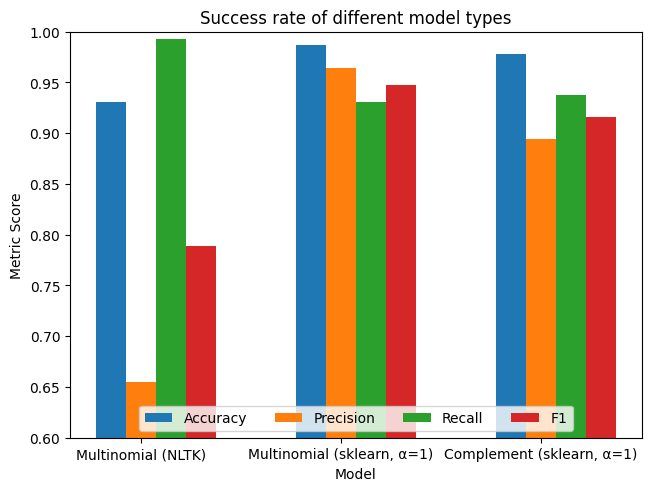

In [30]:
models = ("Multinomial (NLTK)", "Multinomial (sklearn, α=1)", "Complement (sklearn, α=1)")
metrics = {
    "Accuracy": (accuracy_score(dev_tups[1], preds), accuracy_score(dev_tups[1], multi_preds), accuracy_score(dev_tups[1], comp_preds)),
    "Precision": (precision_score(dev_tups[1], preds, pos_label="spam"), precision_score(dev_tups[1], multi_preds, pos_label="spam"), precision_score(dev_tups[1], comp_preds, pos_label="spam")),
    "Recall": (recall_score(dev_tups[1], preds, pos_label="spam"), recall_score(dev_tups[1], multi_preds, pos_label="spam"), recall_score(dev_tups[1], comp_preds, pos_label="spam")),
    "F1": (f1_score(dev_tups[1], preds, pos_label="spam"), f1_score(dev_tups[1], multi_preds, pos_label="spam"), f1_score(dev_tups[1], comp_preds, pos_label="spam"))
}
x = np.arange(len(models))
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for metric, score in metrics.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, score, width, label=metric)
    multiplier += 1

ax.set_xlabel('Model')
ax.set_ylabel('Metric Score')
ax.set_title('Success rate of different model types')
ax.set_xticks(x + width, models)
ax.legend(ncols=4, loc='lower center')
ax.set_ylim(0.6, 1)

plt.savefig("NB_bars.png")
plt.show()

In [28]:
import joblib

# Save model for deployment
joblib.dump(feature_matrix, "featurize.pkl")
joblib.dump(search_multi, "NBmodel.pkl")

['NBmodel.pkl']